# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#pip install --upgrade category_encoders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
random_state = 12345

### Первичный просмотр данных

In [5]:
#data = pd.read_csv('autos.csv')
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

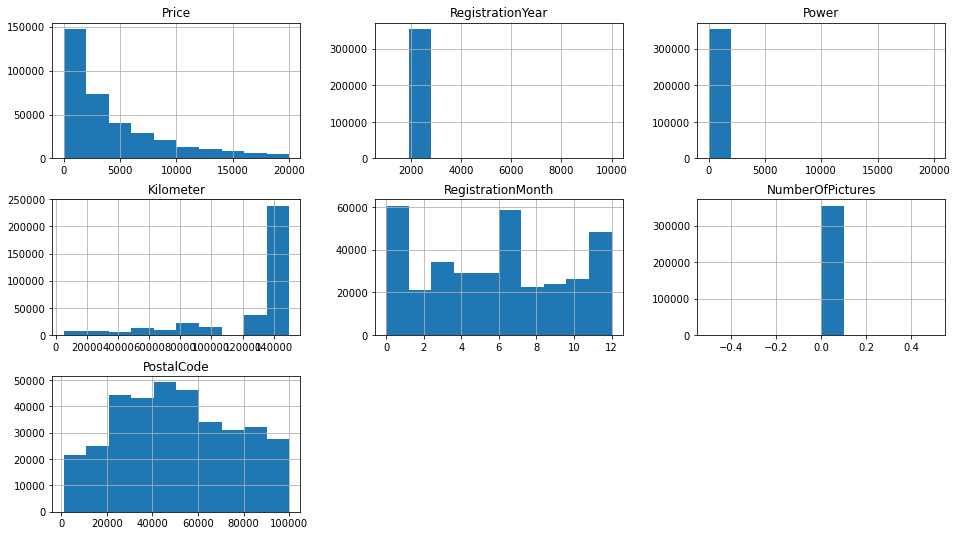

In [8]:
data.hist(figsize=(16,9))

In [9]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Выводы по итогу первичного просмотра
* Есть строки с нулевой ценой. Судя по распределению, их много. Предположительно, их придется исключить из рассмотрения ввиду отсутствия целевого признака.
* В NumberOfPictures только нулевые значения, этот столбец можно полностью игнорировать при обучении моделей.
* RegistrationYear и Power содержат явно аномальные значения
* RegistrationMonth содержит отдельно значения 0 и 12 и имеет завышенные значения в 0, 6 и 12. В данном столбце можно ожидать некоторую сезонность, но такие явные выбросы подозрительны. Скорее всего, они объясняются передискретизацией, поскольку 13 значений раскладываются в 10 "корзин" графика. В любом случае, на целевой признак - стоимость - месяц регистрации сильно влиять не должен.
* В Kilometer также наблюдается странное распределение, где 50% квантиль совпадает с максимальным значением. Предположительно, пробеги большинства автомобилей в выборке больше и для них было выбрано максимально разрешенное интерфейсом значение.
* DateCreated, LastSeen, DateCrawled следует привести к числовому формату. Возможно, следует также рассмотреть разделение признака на год и месяц, чтобы разделить сезонность и зависимость от года размещения. День в месяце можно отбросить как заведомо незначащий признак. Кроме того, если данные не покрывают протяженный период от нескольких лет и более, то все колонки с датами следует отбросить, как заведомо не влияющие на цену.
* В VehicleType, Gearbox, Model, FuelType и Repaired имеются пропуски. Все эти признаки категориальные и их придется так или иначе кодировать вместе с пропусками.
* Сильно коррелирующих признаков нет
* Названия колонок сразу приведем к стандарту snake_case:

In [12]:
data.columns = data.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Обработка пропусков и ошибок в данных

#### Нули в price

In [13]:
data[data['price']==0].shape[0] / data.shape[0]

0.030397692800442477

In [14]:
data[data['price']<50].shape[0] / data.shape[0]

0.03505667820830829

In [15]:
data[(0<data['price']) & (data['price']<50)].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49
408,2016-03-29 18:51:58,1,NaN,2000,NaN,75,golf,90000,3,petrol,volkswagen,NaN,2016-03-29 00:00:00,0,78588,2016-04-06 04:45:50
901,2016-03-06 00:25:25,1,NaN,1990,manual,0,other,150000,0,NaN,porsche,NaN,2016-03-05 00:00:00,0,65843,2016-04-06 20:19:08
967,2016-03-23 08:21:11,1,wagon,1998,manual,136,omega,150000,0,petrol,opel,no,2016-03-22 00:00:00,0,57614,2016-03-27 08:45:52
1025,2016-03-15 18:57:12,3,convertible,1998,manual,110,mx_reihe,150000,11,NaN,mazda,yes,2016-03-15 00:00:00,0,89312,2016-04-06 21:16:58
1076,2016-03-18 07:53:24,45,NaN,2015,NaN,0,other,5000,0,NaN,mini,NaN,2016-03-18 00:00:00,0,37339,2016-04-05 22:15:28
1247,2016-03-24 15:57:20,1,sedan,1983,manual,0,NaN,150000,6,petrol,mercedes_benz,no,2016-03-24 00:00:00,0,53173,2016-04-07 08:45:25
1340,2016-03-16 21:47:22,1,NaN,2016,manual,0,golf,150000,0,gasoline,volkswagen,yes,2016-03-16 00:00:00,0,49401,2016-04-07 09:45:43


Датасет содержит около 3% строк с нулевой ценой и 0.5% строк с ценой ниже 50. Также видно, что есть много строк с ценой равной 1, которые также заведомо ошибочны. Из распределения значений можно предположить, что цены указаны в величинах, соразмерных доллару США, а цены меньше 10 указаны в тысячах. Однако, принимая во внимание малое количество таких строк, а также наличие в них множества пропусков в других колонках, логичнее просто удалить все строки с ценой ниже 50.

In [16]:
datax = data[data['price']<50]

In [17]:
data = data[data['price']>=50]

#### Нули в number_of_pictures

In [19]:
data[data['number_of_pictures']==0].shape[0] / data.shape[0]

1.0

Все значения нулевые. Эта колонка не содержит информации, удаляем.

In [20]:
data = data.drop('number_of_pictures', axis=1)

#### Аномальные значения в registration_year

<AxesSubplot:>

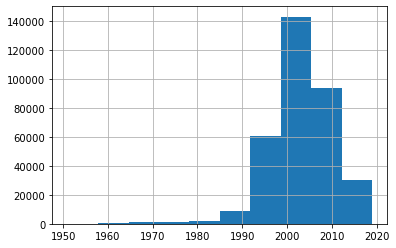

In [21]:
data[(data['registration_year']<2023) & (data['registration_year']>1950)]['registration_year'].hist()

In [22]:
data[data['registration_year']>2023].shape[0] / data.shape[0]

0.00023687950729062482

In [23]:
data[data['registration_year']<1950].shape[0] / data.shape[0]

0.00045036350768834846

Выберем интервал с 1950 по 2022 и выбросим строки, которые туда не попадают. Год выпуска - ключевой параметр автомобиля, который кардинальным образом влияет на цену. Полностью совпадающие по всем прочим параметрам автомобили с разницей даже в десять лет это совершенно разные объекты с точки зрения рынка, поэтому автомобили без возраста ценности для анализа не имеют. Кроме того, таких строк микроскопически мало, поэтому отбрасываем.

In [24]:
data = data[(data['registration_year']<2023) & (data['registration_year']>1950)]

#### Аномальные значения в power

<AxesSubplot:>

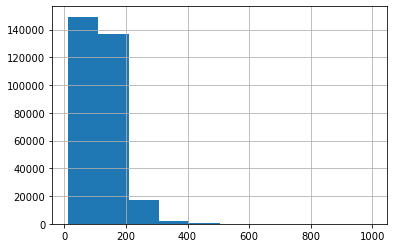

In [25]:
data[(data['power']<1000) & (data['power']>10)]['power'].hist()

In [26]:
data[data['power']==0].shape[0] / data.shape[0]

0.10350690816717735

In [27]:
data[data['power']<10].shape[0] / data.shape[0]

0.10409514862582932

In [28]:
data[data['power']>1000].shape[0] / data.shape[0]

0.0008106597365502184

В колонке power около 10% нулевых значений и 0.1% заведомо ошибочных больших значений. Удалять 10% из-за одного признака не стоит. Будем считать, что нулевая мощность соответствует случаям, когда мощность не указана. Заменим заведомо ошибочные значения нулем.

In [29]:
data['power'] = data['power'].where( (data['power']<1000) & (data['power']>10), 0 )

#### Проверка распределения registration_month

<AxesSubplot:>

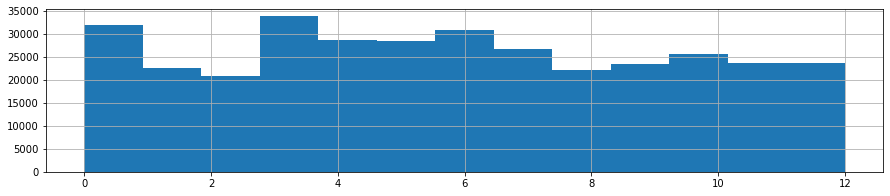

In [30]:
data['registration_month'].hist(bins=13, figsize=(15,3))

Распределение по месяцам ровное. Выбросы при первичном просмотре были обоснованы передискретизацией. Номер месяца принимает 13 значений от 0 до 12. Вероятно, ноль соответствует отсутствию значения. Оставим данный признак в текущем виде.

#### Форматирование date_created, last_seen

Посмотрим, как распределены объявления по датам создания

In [31]:
data['dt_created'] = pd.to_datetime(data['date_created'])
data['dt_created'].dt.year.value_counts()

2016    341671
2015        25
2014         1
Name: dt_created, dtype: int64

In [32]:
data['dt_seen'] = pd.to_datetime(data['last_seen'])
data['dt_seen'].dt.year.value_counts()

2016    341697
Name: dt_seen, dtype: int64

<AxesSubplot:>

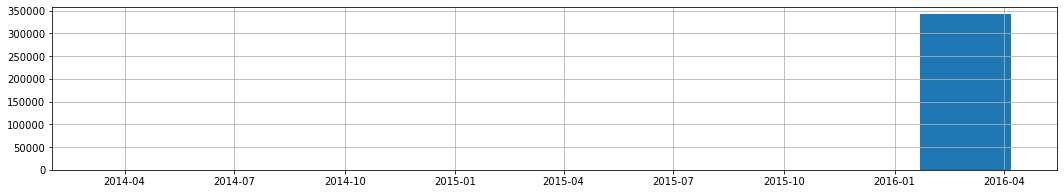

In [33]:
data['dt_created'].hist(figsize=(18,3))

<AxesSubplot:>

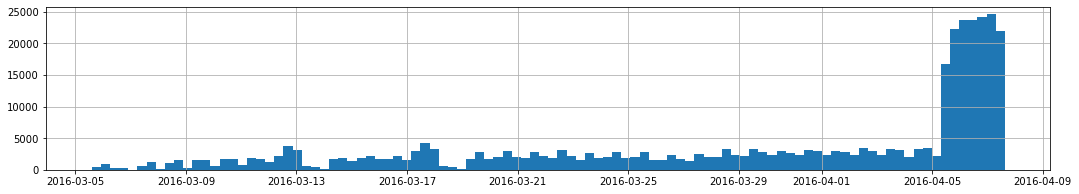

In [34]:
data['dt_seen'].hist(figsize=(18,3), bins=100)

Объявления отдельно за 2016

<AxesSubplot:>

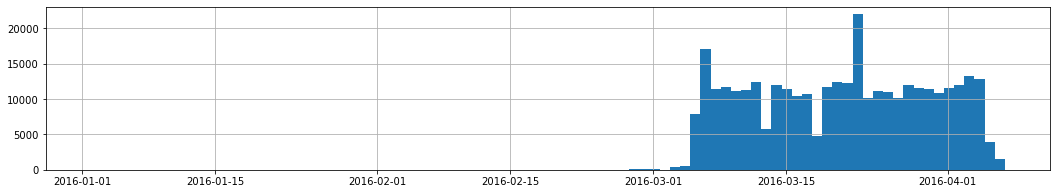

In [35]:
bins_number = data['dt_created'][data['dt_created']>pd.to_datetime('2016-01-01 00:00:00')].dt.round("D").value_counts().count()
data['dt_created'][data['dt_created']>pd.to_datetime('2016-01-01 00:00:00')].dt.round("D").hist(figsize=(18,3), bins=bins_number)

И за март 2016

<AxesSubplot:>

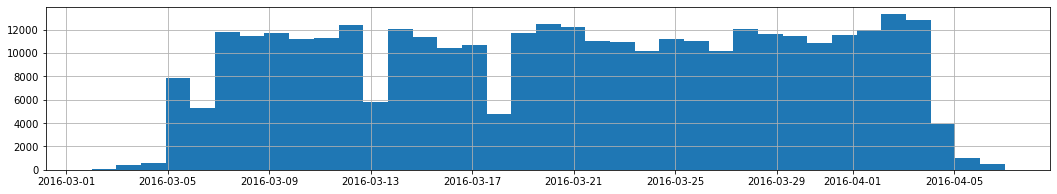

In [36]:
bins_number = data['dt_created'][data['dt_created']>pd.to_datetime('2016-03-01 00:00:00')].dt.round("D").value_counts().count()
data['dt_created'][data['dt_created']>pd.to_datetime('2016-03-01 00:00:00')].dt.round("D").hist(figsize=(18,3), bins=bins_number)

In [37]:
data['dt_created'][data['dt_created']>pd.to_datetime('2016-03-01 00:00:00')].shape[0] / data.shape[0]

0.9984313587769281

Практически все данные соответствуют объявлениям за март 2016 года. Данные признаки можно полностью исключить из рассмотрения, поскольку ценность автомобиля не может зависеть от момента подачи объявления в пределах одного месяца. Любые найденные моделями закономерности для этого признака будут заведомо ложными и будут относиться только к тренировочной выборке. Кроме того, дата последней активности не может быть признаком для рекомендации пользователю, поскольку не известна на момент создания новой анкеты. При наличии выборки за более продолжительный период времени можно было бы учитывать количество дней между подачей объявлений и последней активностью как показатель соответствия цены рынку, но здесь дата последней активности для большинства анкет приходится на последнюю неделю, т.е. не отражает реального окончания активности по анкете. Кроме того, следует исключить анкеты, поданные до 01.03.2016, поскольку все они висели долго, выборка по ним не репрезентативна и цена в них не соответствует рынку.

In [38]:
data = data[data['dt_created']>pd.to_datetime('2016-03-01 00:00:00')]
#data = data.drop(['date_created', 'dt_created', 'last_seen', 'dt_seen', 'date_crawled'], axis=1)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341161 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        341161 non-null  object        
 1   price               341161 non-null  int64         
 2   vehicle_type        308387 non-null  object        
 3   registration_year   341161 non-null  int64         
 4   gearbox             324655 non-null  object        
 5   power               341161 non-null  int64         
 6   model               324129 non-null  object        
 7   kilometer           341161 non-null  int64         
 8   registration_month  341161 non-null  int64         
 9   fuel_type           312624 non-null  object        
 10  brand               341161 non-null  object        
 11  repaired            276558 non-null  object        
 12  date_created        341161 non-null  object        
 13  postal_code         341161 no

### Кодирование категориальных признаков

Категориальные признаки это vehicle_type, gearbox, model, fuel_type, brand, repaired, postal_code. Из них gearbox, fuel_type и repaired предположительно имеют мало различных значений и для них подойдет one hot encoding. Признаки vehicle_type, model, brand и postal_code предположительно будут иметь множество различных значений, для них применим target encoding, т.е. будем кодировать средним значением целевого признака. Пропуски в этих колонках будем рассматривать как отдельную категорию:

In [40]:
categorical_list = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'postal_code']
data[categorical_list] = data[categorical_list].fillna('__Nan')

Посмотрим значения в категориальных признаках

In [41]:
for category in categorical_list:
    print('                                              Название категории:', category)
    print('                                              Всего значений:', data[category].value_counts().count())
    print(data[category].value_counts())
    print()

                                              Название категории: vehicle_type
                                              Всего значений: 9
sedan          89017
small          77679
wagon          63420
__Nan          32774
bus            28227
convertible    19764
coupe          15526
suv            11718
other           3036
Name: vehicle_type, dtype: int64

                                              Название категории: gearbox
                                              Всего значений: 3
manual    260102
auto       64553
__Nan      16506
Name: gearbox, dtype: int64

                                              Название категории: model
                                              Всего значений: 251
golf                  28080
other                 23458
3er                   19067
__Nan                 17032
polo                  12552
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        

Выводы по просмотру значений:
* В model и postal_code есть значения, которые плохо представлены в выборке. По единичным значениям вообще ничего нельзя предсказать. Малое количество значений может плохо распределиться по тренировочной и тестовой выборке. Уберем из выборки значения, которых там меньше 10, и заменим их значением RARE_VALUE.
* Неожиданно, но fuel_type имеет множество значений. Я отстал от жизни и ожидал там petrol/gasoline и diesel. Оказалось, дизельных машин нет, зато есть пропан/бутан, метан и всякая электрика. Это явно американский рынок. Заменим gasoline на petrol, поскольку это все бензин.
* vehicle_type имеет не так много значений и подойдет для one hot encoder
* По прочим признакам явных дубликатов не видно. Прописных букв, которые указывали бы на возможное наличие дубликатов, тоже не видно.

In [42]:
data['fuel_type'] = data['fuel_type'].where(data['fuel_type']!='gasoline', 'petrol')

In [43]:
for category in categorical_list:
    if data[category].value_counts().values[-1]>=10:
        print('Категория:', category, ' нет замен')
    else:
        data.loc[data[category].value_counts()[data[category]].values < 10, category] = 'RARE_VALUE'
        print('Категория:', category,
              ' Всего редких значений:', data[category].value_counts()['RARE_VALUE'],
              ' Осталось уникальных значений', data[category].value_counts().count())

Категория: vehicle_type  нет замен
Категория: gearbox  нет замен
Категория: model  Всего редких значений: 35  Осталось уникальных значений 245
Категория: fuel_type  нет замен
Категория: brand  нет замен
Категория: repaired  нет замен
Категория: postal_code  Всего редких значений: 9983  Осталось уникальных значений 6237


Попробуем разбить выборку на возрастные группы с тем чтобы потом проверить гипотезу о различном ценообразовании для разных групп:

In [44]:
age_list = [0, 3, 7, 15, 30, 100]
age_code_list = ['kinda_new', 'not_so_new', 'kinda_old', 'retro', 'super_retro']

last_year = data['dt_seen'].dt.year.max()

def code_age(year):
    for i in range(len(age_list)-1):
        if age_list[i] <= last_year - year < age_list[i+1]:
            return age_code_list[i]


data['age_code'] = data['registration_year'].apply(code_age)
data['age_code'].value_counts()

kinda_old      144840
retro          132735
not_so_new      31582
kinda_new       12557
super_retro      5839
Name: age_code, dtype: int64

#### Разбиваем на тренировочную, тестовую и валидационную выборки

Кодирование целевым признаком (target encoding) существенно использует информацию о всей выборке, поэтому необходимо выделить тестовую выборку до этапа кодирования. По этой же причине здесь сложно будет использовать кросс-валидацию, поэтому сделаем также отдельную валидационную выборку.

In [45]:
features = data.drop(['price','date_created', 'dt_created', 'last_seen', 'dt_seen', 'date_crawled', 'age_code'], axis=1)
target = data['price']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=random_state)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=random_state)

Строим также отдельный набор признаков _v2 с возрастными категориями, чтобы сравнить результат

In [46]:
features_v2 = data.drop(['price','date_created', 'dt_created', 'last_seen', 'dt_seen', 'date_crawled'], axis=1)
target = data['price']

features_train_valid_v2, features_test_v2, target_train_valid, target_test = train_test_split(
    features_v2, target, test_size=0.2, random_state=random_state)
features_train_v2, features_valid_v2, target_train, target_valid = train_test_split(
    features_train_valid_v2, target_train_valid, test_size=0.25, random_state=random_state)

#### Кодируем методом target encoding

In [47]:
te_categories = ['model', 'brand', 'postal_code']
te = TargetEncoder()
te.fit(features_train[te_categories], target_train)

# сделаем копии для CatBoost. Там в описании настаивают, что без кодирования признаков будет лучше.
features_train_cb = features_train.copy()
features_valid_cb = features_valid.copy()
features_test_cb = features_test.copy()

features_train[te_categories] = te.transform(features_train[te_categories], target_train)
features_valid[te_categories] = te.transform(features_valid[te_categories])
features_test[te_categories] = te.transform(features_test[te_categories])

features_train_v2[te_categories] = te.transform(features_train[te_categories], target_train)
features_valid_v2[te_categories] = te.transform(features_valid[te_categories])
features_test_v2[te_categories] = te.transform(features_test[te_categories])

#### Кодируем методом one hot encoding

In [48]:
ohe_categories = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
ohe.fit(features_train[ohe_categories])

# функция кодирует признаки categories из df кодером ohe
def ohe_df(df, ohe, categories):
    temp_df = pd.concat([df.reset_index(drop=True), pd.DataFrame(ohe.transform(df[categories]),
                                                                 columns=ohe.get_feature_names_out())], axis=1)
    return temp_df.drop(categories, axis=1)

# сделаем для CatBoost отдельно версию без OHE
features_train_te = features_train.copy()
features_valid_te = features_valid.copy()
features_test_te = features_valid.copy()


features_train = ohe_df(features_train, ohe, ohe_categories)
features_valid = ohe_df(features_valid, ohe, ohe_categories)
features_test = ohe_df(features_test, ohe, ohe_categories)

И кодируем отдельный набор признаков _v2 с возрастными категориями

In [49]:
ohe_categories_v2 = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'age_code']
ohe_v2 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
ohe_v2.fit(features_train_v2[ohe_categories_v2])

features_train_v2 = ohe_df(features_train_v2, ohe_v2, ohe_categories_v2)
features_valid_v2 = ohe_df(features_valid_v2, ohe_v2, ohe_categories_v2)
features_test_v2 = ohe_df(features_test_v2, ohe_v2, ohe_categories_v2)

## Иструмент для оптимизации параметров моделей

Модели градиентного бустинга имеют параметры с выраженными оптимальными значениями. Построим алгоритм подбора таких параметров в рамках однопараметрической оптимизации. Стандартный метод оптимизации - градиентный спуск - здесь применять затруднительно, поскольку метрика принципиально недифференцируема по гиперпараметрам моделей вследствие наличия в моделях случайного фактора. Попробуем использовать последовательную аппроксимацию параболой по трем точкам:
* найдем в списке три точки, где метрики в средней по параметру точке меньше, чем в крайних
* найдем параболу, которая через эти точки проходит
* найдем значение параметра, соответствующее минимуму параболы
* вычислим функцию в этом минимуме, добавим эту точку в список
* повторяем процедуру, пока точки не будут достаточно близко

In [50]:
# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

Демонстрация метода на примере тестовой функции:

In [51]:
def lr_test_function(lr):
    return np.sin(0.1*(lr-0.33))**4    

Так работает геометрическая прогрессия, ее будем использовать для learning_rate:

In [52]:
optimizer = one_parameter_parabolic_optimizer([0.1], 1.01, step_method='geometric')
for i in range(100):
    parameter = optimizer.current_value
    print('parameter =', parameter)
    if optimizer.add_metric_value(lr_test_function(parameter)):
        break
    

parameter = 0.1
parameter = 0.05
parameter = 0.2
parameter = 0.4
parameter = 0.8
parameter = 0.3031882977501005
parameter = 0.34351942093078663
parameter = 0.3246829778557888
parameter = 0.33274478266908714
parameter = 0.328986021278812
parameter = 0.33056719258756434


А так дихотомия, ее будем использовать для поиска в заданном интервале:

In [53]:
optimizer = one_parameter_parabolic_optimizer([0,1], 1.01, step_method='dichotomy')
for i in range(100):
    parameter = optimizer.current_value
    print('parameter =', parameter)
    if optimizer.add_metric_value(lr_test_function(parameter)):
        break

parameter = 0
parameter = 1
parameter = 0.5
parameter = 0.2760921444980072
parameter = 0.36823382948330025
parameter = 0.3233625067864423
parameter = 0.3361070868398563
parameter = 0.3297493514299022
parameter = 0.3302608520981937


А так дихотомия средним геометрическим, это для больших интервалов:

In [54]:
optimizer = one_parameter_parabolic_optimizer([0.1,1000], 1.01, step_method='geometric_dichotomy')
for i in range(100):
    parameter = optimizer.current_value
    print('parameter =', parameter)
    if optimizer.add_metric_value(lr_test_function(parameter)):
        break

parameter = 0.1
parameter = 1000
parameter = 10.0
parameter = 1.0
parameter = 0.31622776601683794
parameter = 0.22709198138875084
parameter = 0.2733070110090033
parameter = 0.29506373819343945
parameter = 0.30572813130346904
parameter = 0.31101294949135694
parameter = 0.3136414880999471


## Обучение моделей

### Линейная регрессия

Обучение:

In [55]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: total: 281 ms
Wall time: 144 ms


LinearRegression()

Предсказание:

In [56]:
%%time
mean_squared_error(target_valid, lr_model.predict(features_valid), squared=False)

CPU times: total: 62.5 ms
Wall time: 9 ms


2829.3345982057936

Значение метрики великовато, зато быстро. Запомним результаты:

In [101]:
result_table = pd.DataFrame(columns=('Название модели', 'Лучшее значение RMSE', 
                                     'Время обучения (секунды wall time)', 'Время предсказания', 'Время подбора параметров '))
result_table.loc[result_table.shape[0]] = ['Линейная регрессия', 2829, 0.1, 0.01, 0.1]

### Случайный лес

Параметры леса это max_depth и n_estimators. Первый из них сложно влияет на метрику, второй не имеет оптимума и ограничен временем. Оптимизацию здесь автоматизировать не будем. Попробуем варианты с разными max_depth:

In [57]:
%%time
rf_model = RandomForestRegressor(max_depth=20, n_estimators=50, random_state=random_state)
rf_model.fit(features_train, target_train)
mean_squared_error(target_valid, rf_model.predict(features_valid), squared=False)

CPU times: total: 47.6 s
Wall time: 47.6 s


1611.3688256838495

In [58]:
%%time
rf_model = RandomForestRegressor(max_depth=50, n_estimators=50, random_state=random_state)
rf_model.fit(features_train, target_train)
mean_squared_error(target_valid, rf_model.predict(features_valid), squared=False)

CPU times: total: 57.3 s
Wall time: 57.7 s


1609.5927818304285

Убедимся, что разницы между max_depth=20 и max_depth=50 на валидационной выборке нет. Прикинем вариант, который считается около пяти минут, чтобы сравнивать его результаты с бустингом:

In [59]:
%%time
rf_model = RandomForestRegressor(max_depth=30, n_estimators=200, random_state=random_state)
rf_model.fit(features_train, target_train)

CPU times: total: 3min 38s
Wall time: 3min 40s


RandomForestRegressor(max_depth=30, n_estimators=200, random_state=12345)

Предсказание:

In [60]:
%%time
mean_squared_error(target_valid, rf_model.predict(features_valid), squared=False)

CPU times: total: 5.02 s
Wall time: 5.08 s


1595.632060895015

И сделаем вывод, что накруткой количества деревьев много точности мы здесь уже не получим.

In [102]:
result_table.loc[result_table.shape[0]] = ['Случайный лес', 1596, 220, 5, 330]

### Бустинг LightGBM

Основные параметры LightGBM это сложность дерева (num_leaves), шаг бустинга (learning_rate) и количество шагов (num_iterations). num_iterations определяет время счета, сложность дерева должна быть достаточной, а шаг сразу подберем оптимизацией.

In [61]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.3], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = LGBMRegressor(num_leaves=200, learning_rate=learning_rate, num_iterations=400, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'learning rate = {learning_rate:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_learning_rate_400 = optimizer.best_value()

learning rate = 0.30000 rmse = 1613.5
learning rate = 0.15000 rmse = 1568.5
learning rate = 0.07500 rmse = 1568.3
learning rate = 0.03750 rmse = 1582.7
learning rate = 0.11202 rmse = 1562.5
learning rate = 0.11211 rmse = 1566.5
CPU times: total: 1min 21s
Wall time: 22.4 s


Сходу счетом на 20 секунд обогнали четырехминутное случайное дерево. Похоже, что бустиг эффективнее бэггинга. Теперь зафиксируем параметры бустинга и поищем оптимальное num_leaves:

In [62]:
%%time
optimizer = one_parameter_parabolic_optimizer([50, 1000], 1.03, step_method='geometric_dichotomy')
for i in range(10):
    num_leaves = int(optimizer.current_value)
    lgbm_model = LGBMRegressor(num_leaves=num_leaves, learning_rate=best_learning_rate_400, 
                               num_iterations=400, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'num_leaves = {num_leaves:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_num_leaves = int(optimizer.best_value())

num_leaves = 50.00000 rmse = 1601.9
num_leaves = 1000.00000 rmse = 1571.4
num_leaves = 223.00000 rmse = 1565.2
num_leaves = 594.00000 rmse = 1567.7
num_leaves = 400.00000 rmse = 1561.9
num_leaves = 383.00000 rmse = 1561.3
num_leaves = 341.00000 rmse = 1559.2
num_leaves = 322.00000 rmse = 1561.5
num_leaves = 353.00000 rmse = 1562.2
num_leaves = 336.00000 rmse = 1562.0
CPU times: total: 3min 23s
Wall time: 56.8 s


Разница минимальна, а считает с большим num_leaves дольше. Но проверку разумности наших значений имеем. Попробуем пошевелить еще параметр feature_fraction:

In [63]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.1, 1], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate_400,  
                               num_iterations=400, 
                               feature_fraction=feature_fraction, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'feature_fraction = {feature_fraction:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_feature_fraction = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
feature_fraction = 0.10000 rmse = 1662.7
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
feature_fraction = 1.00000 rmse = 1559.2
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
feature_fraction = 0.55000 rmse = 1549.4
[LightGBM] [Warning] feature_fraction is set=0.7390799028973889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7390799028973889
feature_fraction = 0.73908 rmse = 1550.1
[LightGBM] [Warning] feature_fraction is set=0.6400243497561908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6400243497561908
feature_fraction = 0.64002 rmse = 1550.9
[LightGBM] [Warning] feature_fraction is set=0.5783692561147507, colsample_bytree=1.0 will be ignored. Current value:

А здесь прогресс заметен. Попробуем теперь с проверенными параметрами сделать чуть больше итераций бустинга. Поскольку это повторная оптимизация по learning_rate, начинаем с известного значения. Для ускорения процесса сделаем ровно 4 шага оптимизации, из них 3 первых точки позволят построить параболическую аппроксимацию, а четвертую посчитаем в вершине параболы.

In [64]:
%%time
optimizer = one_parameter_parabolic_optimizer([best_learning_rate_400], 1.03, step_method='geometric')
for i in range(4):
    learning_rate = optimizer.current_value
    lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=learning_rate,  num_iterations=1000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'learning_rate = {learning_rate:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_learning_rate_1000 = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
learning_rate = 0.11202 rmse = 1548.3
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
learning_rate = 0.05601 rmse = 1533.1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
learning_rate = 0.02800 rmse = 1538.9
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
learning_rate = 0.06008 rmse = 1531.9
CPU times: total: 3min 17s
Wall time: 54.9 s


Количество шагов улучшает точность. Случайное дерево осталось далеко позади. Остановимся на этой полутораминутной оптимизации и запомним параметры.

In [65]:
%%time
lgbm_model_best = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate_1000,  num_iterations=1000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model_best.fit(features_train, target_train)
mean_squared_error(target_valid, lgbm_model_best.predict(features_valid), squared=False)

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
CPU times: total: 47.4 s
Wall time: 13.2 s


1531.8887170590372

Проверим, нет ли явно выраженного переобучения по num_leaves:

In [66]:
%%time
lgbm_model = LGBMRegressor(num_leaves=2*best_num_leaves//3, learning_rate=best_learning_rate_1000,  num_iterations=1000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model.fit(features_train, target_train)

rmse_train_best = mean_squared_error(target_train, lgbm_model_best.predict(features_train), squared=False)
rmse_valid_best = mean_squared_error(target_valid, lgbm_model_best.predict(features_valid), squared=False)
rmse_train = mean_squared_error(target_train, lgbm_model.predict(features_train), squared=False)
rmse_valid = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
print(f'best_num_leaves      ----> RMSE train = {rmse_train_best:.1f}, RMSE valid = {rmse_valid_best:.1f}')
print(f'2*best_num_leaves//3 ----> RMSE train = {rmse_train:.1f}, RMSE valid = {rmse_valid:.1f}')

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
best_num_leaves      ----> RMSE train = 980.2, RMSE valid = 1531.9
2*best_num_leaves//3 ----> RMSE train = 1091.6, RMSE valid = 1540.7
CPU times: total: 1min 31s
Wall time: 25.2 s


При уменьшении num_leaves в полтора раза метрика заметно падает как на тренировочной выборке, так и на валидационной. Явно выраженного переобучения не наблюдается. Добавим еще итераций, пропорционально уменьшая learning_rate:

In [67]:
%%time
lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate_1000/5,  num_iterations=5000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
CPU times: total: 3min 12s
Wall time: 54.2 s


LGBMRegressor(feature_fraction=0.55, learning_rate=0.012016180110745931,
              num_iterations=5000, num_leaves=341, random_state=12345)

Предсказание:

In [68]:
%%time
mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)

CPU times: total: 2min 6s
Wall time: 33.3 s


1525.2062795178804

In [103]:
result_table.loc[result_table.shape[0]] = ['LightGBM', 1525, 54, 33, 300]

И на этом результате остановимся.

Применяем лучшую модель к набору признаков _v2 с возрастными категориями, чтобы сравнить результат

In [69]:
%%time
lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate_1000/5,  num_iterations=5000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model.fit(features_train_v2, target_train)

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
CPU times: total: 3min 14s
Wall time: 55.1 s


LGBMRegressor(feature_fraction=0.55, learning_rate=0.012016180110745931,
              num_iterations=5000, num_leaves=341, random_state=12345)

In [70]:
%%time
mean_squared_error(target_valid, lgbm_model.predict(features_valid_v2), squared=False)

CPU times: total: 2min 47s
Wall time: 43.7 s


1812.0744781629642

С набором признаков _v2 получилось кошмарно плохо, намного хуже даже случайного леса с обычными признаками. Неожиданный, честно говоря, результат. Предположение о том, что возраст можно заменить категорией "возрастная группа" не подтвердилось.

### Бустинг CatBoost

Основные параметры CatBoost совпадают с параметрами LightGBM. Это max_leaves для моделей, learning_rate и n_estimators для бустинга. max_leaves ограничена значением max_depth, которая, в свою очередь, ограничена значением 16 для расчетов на GPU. Первым шагом оценим оптимальное learning_rate:

In [71]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.3], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    catboost_model = CatBoostRegressor(max_leaves=64, n_estimators=400, learning_rate=learning_rate, grow_policy='Lossguide',
                                       verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
    catboost_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, catboost_model.predict(features_valid), squared=False)
    print(f'learning rate = {learning_rate:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_learning_rate_cb_400 = optimizer.best_value()

learning rate = 0.30000 rmse = 1608.4
learning rate = 0.15000 rmse = 1606.4
learning rate = 0.07500 rmse = 1632.1
learning rate = 0.22076 rmse = 1600.0
learning rate = 0.21985 rmse = 1600.4
CPU times: total: 1min 56s
Wall time: 1min 14s


Результат пока не впечатляет, у LightGBM за то же время получилось значительно лучше. В описании CatBoost рекомендуют не кодировать параметры. Попробуем варианты без кодировния вообще:

In [72]:
%%time
catboost_model = CatBoostRegressor(max_leaves=64, n_estimators=400, learning_rate=learning_rate, grow_policy='Lossguide',
                                   verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
catboost_model.fit(features_train_cb, target_train, cat_features = categorical_list)
mean_squared_error(target_valid, catboost_model.predict(features_valid_cb), squared=False)

CPU times: total: 30.8 s
Wall time: 18.4 s


1624.2248492918304

Стало медленнее и хуже. Попробуем отдельно без OHE:

In [73]:
%%time
catboost_model = CatBoostRegressor(max_leaves=64, n_estimators=400, learning_rate=learning_rate, grow_policy='Lossguide',
                                   verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
catboost_model.fit(features_train_te, target_train, cat_features = ohe_categories)
mean_squared_error(target_valid, catboost_model.predict(features_valid_te), squared=False)

CPU times: total: 33.7 s
Wall time: 19.6 s


1611.3431775447227

Так тоже не лучше. Попробуем пошевелить max_leaves:

In [74]:
%%time
optimizer = one_parameter_parabolic_optimizer([11,101], 1.03, step_method='dichotomy')
for i in range(10):
    max_leaves = int(optimizer.current_value)
    catboost_model = CatBoostRegressor(max_leaves=max_leaves, n_estimators=400, learning_rate=best_learning_rate_cb_400, 
                                       grow_policy='Lossguide', verbose=False, 
                                       random_state=random_state, task_type='GPU', loss_function='RMSE')
    catboost_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, catboost_model.predict(features_valid), squared=False)
    print(f'max_leaves = {max_leaves:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_max_leaves_cb_400 = optimizer.best_value()

max_leaves = 11.00000 rmse = 1668.7
max_leaves = 101.00000 rmse = 1600.0
max_leaves = 56.00000 rmse = 1606.2
max_leaves = 78.00000 rmse = 1600.0
max_leaves = 89.00000 rmse = 1600.0
max_leaves = 94.00000 rmse = 1600.0
max_leaves = 92.00000 rmse = 1600.0
CPU times: total: 2min 40s
Wall time: 1min 38s


При max_leaves>64 получаем идентичный результат. Вероятно, это ограничение со стороны max_depth. Зададим этот параметр:

In [75]:
%%time
catboost_model = CatBoostRegressor(max_depth=8, max_leaves=64, n_estimators=400, learning_rate=best_learning_rate_cb_400, grow_policy='Lossguide',
                                       verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
catboost_model.fit(features_train, target_train)
mean_squared_error(target_valid, catboost_model.predict(features_valid), squared=False)

CPU times: total: 26.4 s
Wall time: 16.9 s


1595.972700114546

In [76]:
%%time
catboost_model = CatBoostRegressor(max_depth=16, max_leaves=64, n_estimators=400, learning_rate=best_learning_rate_cb_400, grow_policy='Lossguide',
                                       verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
catboost_model.fit(features_train, target_train)
mean_squared_error(target_valid, catboost_model.predict(features_valid), squared=False)

CPU times: total: 30.8 s
Wall time: 19.7 s


1590.2423694023323

In [77]:
%%time
catboost_model = CatBoostRegressor(max_depth=16, max_leaves=201, n_estimators=400, learning_rate=best_learning_rate_cb_400, 
                                   grow_policy='Lossguide',
                                       verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
catboost_model.fit(features_train, target_train)
mean_squared_error(target_valid, catboost_model.predict(features_valid), squared=False)

CPU times: total: 1min 29s
Wall time: 57.6 s


1571.1191456662839

Так получается значительно обогнать случайный лес, но считается уже целую минуту и все равно уступает LightGBM. Попробуем больше шагов:

In [78]:
%%time
catboost_model = CatBoostRegressor(max_depth=16, max_leaves=201, n_estimators=1000, learning_rate=best_learning_rate_cb_400/2.5, 
                                   grow_policy='Lossguide',
                                       verbose=False, random_state=random_state, task_type='GPU', loss_function='RMSE')
catboost_model.fit(features_train, target_train)

CPU times: total: 3min 45s
Wall time: 2min 25s


Предсказание:

In [79]:
%%time
mean_squared_error(target_valid, catboost_model.predict(features_valid), squared=False)

CPU times: total: 1.08 s
Wall time: 280 ms


1543.2940225373593

Уже неплохой результат, но с LightGBM получилось лучше.

In [105]:
result_table.loc[result_table.shape[0]] = ['CatBoost', 1543, 145, 0.3, 445]

### Финальное обучение лучшей модели и проверка на тестовой выборке

Модель LightGBM с оптимальными параметрами обучим на совокупности тренировочной и валидационной выборок:

In [80]:
%%time
best_lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate_1000/5,  num_iterations=5000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model.fit( pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
CPU times: total: 4min 2s
Wall time: 1min 6s


LGBMRegressor(feature_fraction=0.55, learning_rate=0.012016180110745931,
              num_iterations=5000, num_leaves=341, random_state=12345)

Предсказание:

In [81]:
%%time
rmse = mean_squared_error(target_test, lgbm_model.predict(features_test), squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {rmse:.1f}')

RMSE лучшей модели на тестовой выборке: 1507.4
CPU times: total: 1min 55s
Wall time: 30.5 s


Результат на тестовой выборке закономерно улучшился за счет увеличения тренировочной

In [106]:
result_table.loc[result_table.shape[0]] = ['Финальная LGBM', 1507, 66, 30, 396]

Посмотрим на важность признаков в разных моделях. Сортируем по лучшей модели:

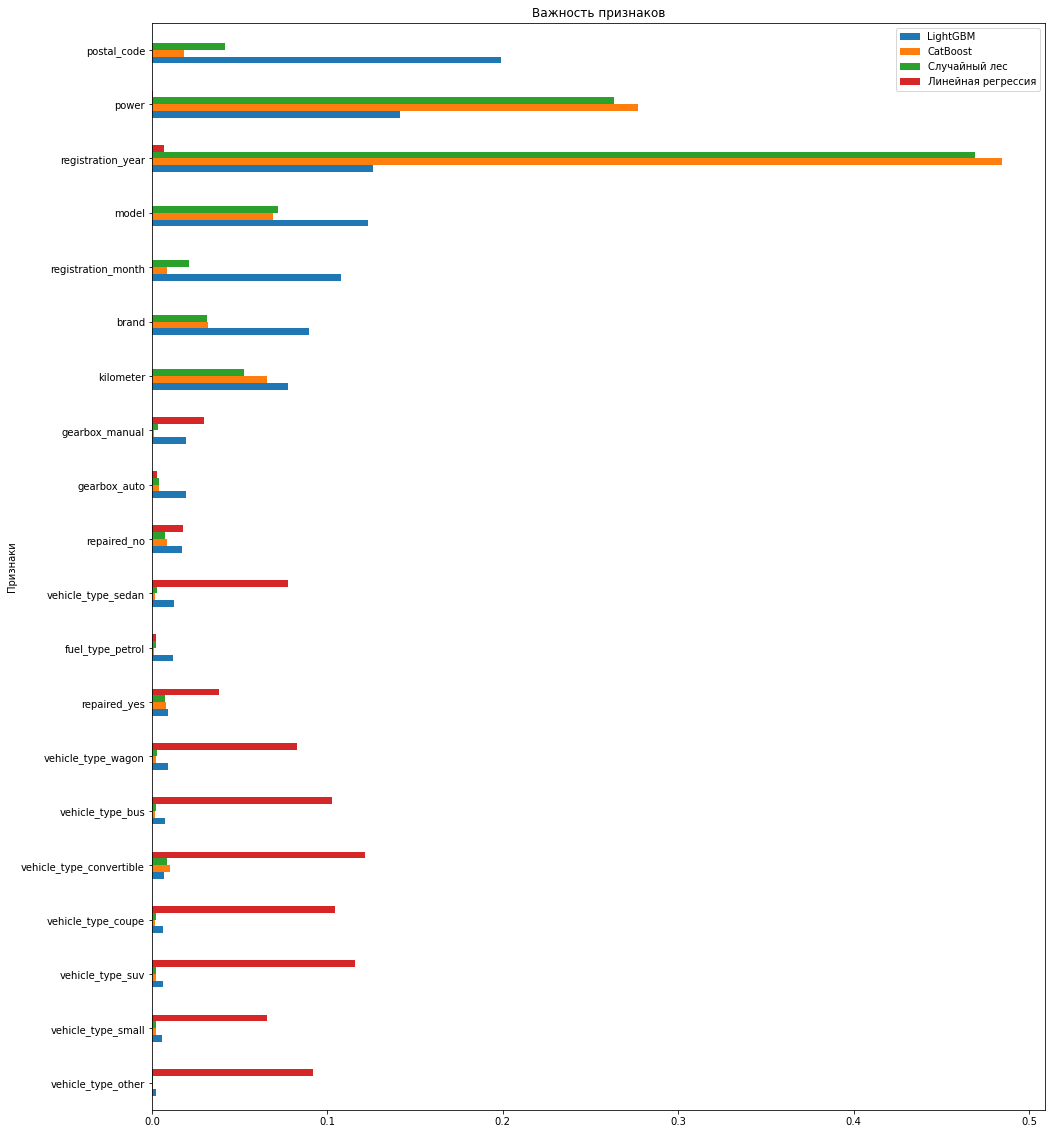

In [82]:
feature_imp = pd.DataFrame({'LightGBM':lgbm_model.feature_importances_, 
                            'CatBoost':catboost_model.feature_importances_, 
                            'Случайный лес':rf_model.feature_importances_,
                            'Линейная регрессия':lr_model.coef_,
                            'Признаки':features_train.columns})
feature_imp['LightGBM'] = feature_imp['LightGBM']/feature_imp['LightGBM'].sum()
feature_imp['CatBoost'] = feature_imp['CatBoost']/feature_imp['CatBoost'].sum()
feature_imp['Случайный лес'] = feature_imp['Случайный лес']/feature_imp['Случайный лес'].sum()
feature_imp['Линейная регрессия'] = abs(feature_imp['Линейная регрессия'])/abs(feature_imp['Линейная регрессия']).sum()
feature_imp.sort_values(by='LightGBM').tail(20).plot(kind = 'barh', x='Признаки',figsize=(16,20), title='Важность признаков')
plt.show()

Интересно, что лучшая модель сочла важнейшим признаком почтовый индекс, а остальные проигнорировали его. Еще интересно, что CatBoost довольно точно сошелся со случайным лесом. И предсказывает он тоже очень быстро, в отличие от LightGBM. Не строит ли CatBoost в процессе обучения именно одно дерево? Линейная регрессия вообще расставила коэффициенты исключительно на мелкие признаки из OHE, но для придания ее коэффициентам смысла пришлось бы сначала признаки нормировать. Не будем.

## Анализ моделей и выводы

Представим таблицу с совокупными результатами по всем моделям и подведем итоги:

In [109]:
result_table.sort_values(by='Лучшее значение RMSE').reset_index(drop=True)

,Название модели,Лучшее значение RMSE,Время обучения (секунды wall time),Время предсказания,Время подбора параметров
0,Финальная LGBM,1507,66.0,30.00,396.0
1,LightGBM,1525,54.0,33.00,300.0
2,CatBoost,1543,145.0,0.30,445.0
3,Случайный лес,1596,220.0,5.00,330.0
4,Линейная регрессия,2829,0.1,0.01,0.1


* В работе построены и обучены модели методами Linear Regression, Random Forest, LightGBM и CatBoost
* Проведенное сравнение на валидационной выборке показало явное преимущество бустинга над ансамблем независимых моделей в точности
* LightGBM характеризуется значительными затратами времени на предсказания в сравнении с Random Forest
* CatBoost предсказывает очень быстро, несмотря на сложность модели
* Достигнутые значения RMSE на валидационной выборке составляют 2830 для Linear Regression, 1595 для Random Forest, 1540 для CatBoost и 1525 для LightGBM
* Указанные результаты приведены для примерно равных значений времени выполнения в 90-150 секунд
* Предложенный и реализованный в виде отдельного класса метод последовательной оптимизации моделей по одному параметру путем аппроксимации метрики параболами позволил значительно улучшить предсказания, особенно для модели LightGBM
* В работе не удалось подтвердить заявленное преимущество CatBoost в точности предсказаний, несмотря на использование GPU
* Также не подтвердилась рекомендация не кодировать для CatBoost признаки
* На тестовой выборке моделью LightGBM достигнуто значение RMSE=1507
* Медианное значение цены в анкете равно 2700. Соответственно, RMSE=1507 - довольно значительная ошибка.